idea: try using Clustering(Unsupervised Learning) for preprocessing
- step 1: cluster observations (X_train only) into multiple loan applicant profiles
        - K-means
        - DBSCAN
        - Agglomerative clustering
- step 2: use cluster assignment as a feature to create a classifier. Alternatively, include cluster assignment as one of the features

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, average_precision_score, accuracy_score

In [71]:
from glob import glob
glob('./*')

['./Predict_bad_loan.ipynb',
 './Loan_Dataset.csv',
 './Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 './Loan_Dataset_2.csv',
 './Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 './Predict_bad_loan_cont_(all_combined).ipynb',
 './variable_descriptions']

In [72]:
df = pd.read_csv('Loan_Dataset_2.csv')
df.head()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,annual_income_log,...,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1
0,11454641,100000,1,1,26.27,43.2,0.0,0.160624,0,11.512935,...,0,0,0,0,0,0,1,0,0,1
1,9604874,83000,0,4,5.39,21.5,0.0,0.810777,0,11.326608,...,0,0,0,0,0,0,1,0,1,0
2,9684700,78000,0,11,18.45,46.3,0.0,0.035147,1,11.264477,...,0,0,0,0,0,0,0,1,0,1
3,9695736,37536,0,6,12.28,10.7,0.0,0.534887,1,10.533082,...,1,0,0,0,0,0,0,1,1,0
4,9795013,65000,0,11,11.26,15.2,0.0,0.166500,0,11.082158,...,0,0,0,0,0,0,1,0,1,0


In [73]:
X = df.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

y = df['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
X_train

array([[ 2.78251958, -1.54570536,  1.08995282, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651, -1.01560908,  0.56622987, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651,  0.04458349, -0.63385889, ..., -0.06613603,
        -0.58185516,  0.90625127],
       ...,
       [-0.35938651,  1.10477606,  0.44780006, ..., -0.06613603,
        -0.58185516, -1.10344673],
       [-0.35938651, -0.48551279, -0.87203441, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651,  1.10477606, -1.67604124, ..., -0.06613603,
        -0.58185516,  0.90625127]])

In [75]:
def get_metrics(target_test, target_score):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    pr_auc = average_precision_score(y_test, y_score)
    print(f'AUC is {pr_auc:.2f}')
    return precision, recall, pr_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

### K-Means

#### Logistic Regression

Attempt 1: classifier is trained on cluster assignments only

In [109]:
lg_clf = LogisticRegression(class_weight='balanced', 
                                   C=10,
                                   max_iter=10000,
                                   random_state = 123)

In [94]:
lg_clf = LogisticRegression(class_weight='balanced', 
                                   C=10,
                                   max_iter=10000,
                                   random_state = 123)

pipeline = Pipeline([
    #The output of this step is the cluster assignments for each data point in the input dataset
    ('kmeans', KMeans()),
    #The logistic regression model is trained on the cluster assignments 
    #(features) and the corresponding labels (target)
    ('log_reg', lg_clf)
])

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 0, n_jobs=-1)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'kmeans__n_clusters': 2}

In [95]:
grid_clf.best_estimator_

Pipeline(steps=[('kmeans', KMeans(n_clusters=2)),
                ('log_reg',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=10000, random_state=123))])

In [96]:
best_pl = grid_clf.best_estimator_
best_pl.fit(X_train, y_train)
y_pred = best_pl.predict(X_test)
y_score = best_pl.predict_proba(X_test)[:,1]

In [97]:
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2175,762
Actual Positive,433,304


In [98]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.28


Performance got much worse

Attempt 2: what if the cluster assignment becomes one of the features

In [104]:
kmeans_model = best_pl['kmeans']
train_cluster_assignments = kmeans_model.fit_predict(X_train).reshape(-1,1)
test_cluster_assignments = kmeans_model.predict(X_test).reshape(-1,1)

In [105]:
X_train_km = np.hstack((X_train, train_cluster_assignments))
X_train_km.shape, X_train.shape

((14696, 29), (14696, 28))

In [106]:
X_test_km = np.hstack((X_test, test_cluster_assignments))
X_test_km.shape, X_test.shape

((3674, 29), (3674, 28))

In [111]:
lg_clf.fit(X_train_km, y_train)
y_pred = lg_clf.predict(X_test_km)
y_score = lg_clf.predict_proba(X_test_km)[:,1]

In [112]:
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1922,1015
Actual Positive,244,493


In [114]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.39


Same performance as the log reg in Predict_bad_loan.ipynb

#### XGBoost

In [117]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_km, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 95}

In [118]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train_km, y_train)
y_pred = xgb_classifier.predict(X_test_km)
y_score = xgb_classifier.predict_proba(X_test_km)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2933,4
Actual Positive,725,12


In [119]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


In [134]:
features = list(X.columns)
features.append('cluster')

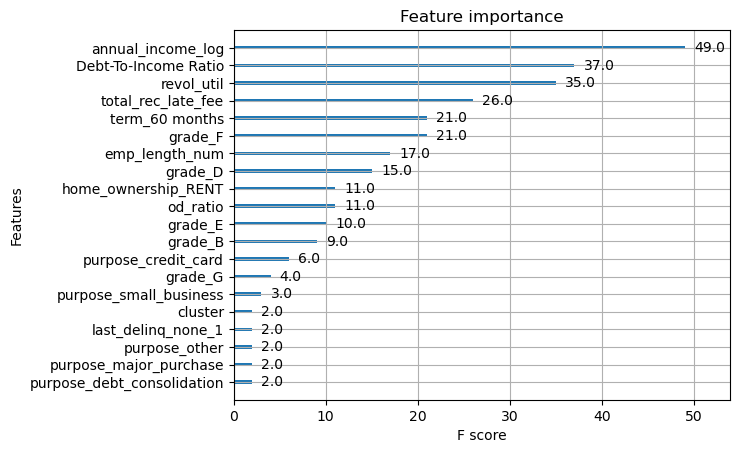

In [136]:
xgb_classifier.get_booster().feature_names =  features
xgb.plot_importance(xgb_classifier);

the importance of the new feature, 'cluster', is low according to xgb's importance chart above.
see if there is a pattern about the target variable in these clusters

In [157]:
kmeans_model

KMeans(n_clusters=2)

In [156]:
num_cluster = 2

for cluster in list(range(num_cluster)):
    default_p = (y_train[train_cluster_assignments.ravel()==cluster]).mean()
    print(f'In Cluster {cluster}, the percentage of defaulted loan is {default_p*100: .0f}%.')

In Cluster 0, the percentage of defaulted loan is  20%.
In Cluster 1, the percentage of defaulted loan is  20%.


cry. both clusters contain 20% bad loans. it is the same pattern as that in the original dataset. conclusion: kmeans cluster as an additional feature does not help improve classifers' performances. both of log reg and xgb classifiers' AUC's verify such.

### DBSCAN

In [160]:
dbscan = DBSCAN(eps = 6, min_samples = 3) #need to find the optimal hyperparameters
dbscan.fit(X_train)

DBSCAN(eps=6, min_samples=3)

In [161]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [162]:
print(f'In the X_train dataset, there are {len(set(dbscan.labels_))} clusters or unique labels, and \
{(dbscan.labels_ ==  -1).sum()} of the data points are anomalies.')

In the X_train dataset, there are 13 clusters or unique labels, and 22 of the data points are anomalies.


In [163]:
len(dbscan.labels_), X_train.shape[0]

(14696, 14696)

In [164]:
X_train_dbscan_label = dbscan.labels_.reshape(-1, 1)

DBSCAN class does not have a predict() method. Use KNN to predict the cluster for X_test based on maximum distance

In [165]:
#the n_neighbors parameter determines the number of neighbors that will be considered when making predictions
knn = KNeighborsClassifier(n_neighbors = 50)

#core instances are in the components_ instance variable
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [167]:
#1. find the nearest neighbor of the data points X_test using the k-nearest neighbors algorithm
dist, pred_idx = knn.kneighbors(X_test, n_neighbors = 1)

#2. identify the cluster labels of the nearest neighbor
label_pred = dbscan.labels_[dbscan.core_sample_indices_][pred_idx]

#3. to label anomalies, identify points that are not close enough  (> 6)
#to any cluster and consider them outliers.
label_pred[dist > 6] = -1

label_pred = label_pred.ravel()

In [168]:
set(label_pred), len(label_pred), X_test.shape[0]

({-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11}, 3674, 3674)

In [169]:
X_test_dbscan_label = label_pred.reshape(-1, 1)

#### Logistic Regression

Attempt 1: classifier is trained on DBSCAN labels only

In [172]:
X_train_dbscan_label.shape

(14696, 1)

In [173]:
lg_clf.fit(X_train_dbscan_label, y_train)
y_pred = lg_clf.predict(X_test_dbscan_label)
y_score = lg_clf.predict_proba(X_test_dbscan_label)[:,1]
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,140,2797
Actual Positive,46,691


In [174]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.21


Attempt 2: DBSCAN label becomes one of the features

In [179]:
X_train_dbscan = np.hstack((X_train, dbscan.labels_.reshape(-1,1)))
X_train_dbscan.shape, X_train.shape

((14696, 29), (14696, 28))

In [180]:
X_test_dbscan = np.hstack((X_test, label_pred.reshape(-1,1)))
X_test_dbscan.shape, X_test.shape

((3674, 29), (3674, 28))

In [181]:
lg_clf.fit(X_train_dbscan, y_train)
y_pred = lg_clf.predict(X_test_dbscan)
y_score = lg_clf.predict_proba(X_test_dbscan)[:,1]
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1921,1016
Actual Positive,243,494


In [182]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


0.01 worse in performance compared with the log reg in Predict_bad_loan.ipynb

#### XGBoost

In [184]:
xgb_classifier.fit(X_train_dbscan, y_train)
y_pred = xgb_classifier.predict(X_test_dbscan)
y_score = xgb_classifier.predict_proba(X_test_dbscan)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2933,4
Actual Positive,725,12


In [185]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


In [186]:
features = list(X.columns)
features.append('dbscan_label')

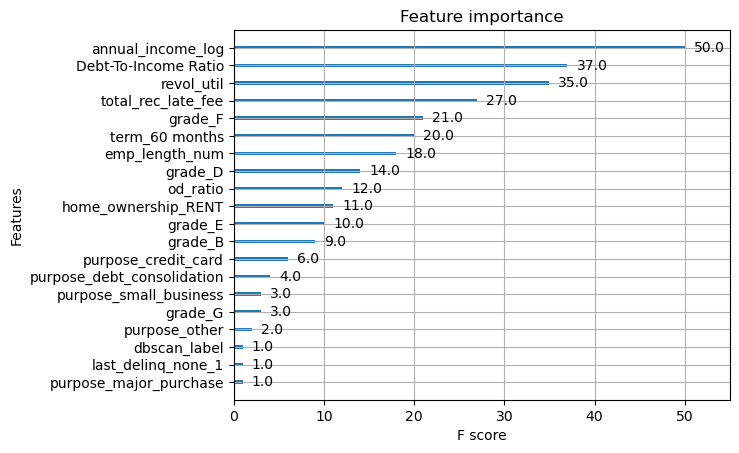

In [187]:
xgb_classifier.get_booster().feature_names =  features
xgb.plot_importance(xgb_classifier);

conclusion: neither DBSCAN label as a lone feature or an additional feature helps improve performance. perhaps tuning the hyperparameters more might help. ?

### Agglomerative Hierarchical Clustering

In [45]:
connect = kneighbors_graph(X_train, n_neighbors=5, include_self=False)
connectivity = cluster.AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                              linkage='complete', connectivity=connect).fit_predict(X_train)

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:550: UserWarning: the number of connected components of the connectivity matrix is 16 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [46]:
print(*["Cluster "+str(i)+": "+ str(sum(connectivity==i)) for i in range(12)], sep='\n')

Cluster 0: 92
Cluster 1: 3
Cluster 2: 2
Cluster 3: 128
Cluster 4: 14145
Cluster 5: 76
Cluster 6: 65
Cluster 7: 1
Cluster 8: 72
Cluster 9: 2
Cluster 10: 108
Cluster 11: 2


In [66]:
#see if there is a pattern about the target variable in these clusters
num_cluster = np.unique(connectivity)

for cluster in num_cluster:
    default_p = (y_train[connectivity==cluster]).mean()
    print(f'In Cluster {cluster}, the percentage of defaulted loan is {default_p*100: .0f}%.')

In Cluster 0, the percentage of defaulted loan is  26%.
In Cluster 1, the percentage of defaulted loan is  67%.
In Cluster 2, the percentage of defaulted loan is  100%.
In Cluster 3, the percentage of defaulted loan is  22%.
In Cluster 4, the percentage of defaulted loan is  20%.
In Cluster 5, the percentage of defaulted loan is  24%.
In Cluster 6, the percentage of defaulted loan is  25%.
In Cluster 7, the percentage of defaulted loan is  100%.
In Cluster 8, the percentage of defaulted loan is  14%.
In Cluster 9, the percentage of defaulted loan is  100%.
In Cluster 10, the percentage of defaulted loan is  41%.
In Cluster 11, the percentage of defaulted loan is  50%.


Most of the major clusters, such as 0, 3, 4, 5, 6, have around 20% bad loans, just like the full dataset. Seems like the clustering action does not classify loan applicants in a way that can help with default prediction.